In [1]:
import sys
import datetime
import tempfile
import re
import math
import json
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
from easyocr import Reader
import cv2
from PIL import Image
import imutils
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import pytesseract
from pytesseract import Output

In [2]:
cv2.__version__

'4.5.4'

In [3]:
pytesseract.get_tesseract_version() 
# pytesseract.__version__

<Version('4.1.1')>

- x = xmin
- y = ymin
- w = xmax - xmin
- h = ymax - ymin

- cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),15)

In [4]:
def plt_imshow(title='image', img=None, figsize=(20 ,10)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [5]:
def crop_image(image, width=420, height=540):
    """
    흰색바탕의 A4크기의 배경에서 수출입신고서 외곽 인식
    Input : image --> 이미지(bgr image)
    return : rot_rect --> 4개의 사각형 좌표와 기운 정도를 나타내는 각도 정보
    """
    crop_success = False
    org_image = image.copy()
    draw_image = image.copy()
    
    image = imutils.resize(image, width=width, height=height)
    ratio = org_image.shape[1] / float(image.shape[1])
    
    ## (1) 이미지 이진화, 흰색부분을 검은색으로 면허증 부분은 흰색으로
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = cv2.bitwise_not(gray)
    th, threshed = cv2.threshold(binary, 10, 255, cv2.THRESH_BINARY)

    ## (2) Find the max-area contour
    (contours,_) = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 면적이 큰거 5개만 추출
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:2]

    screenCnt = None
    for index,c in enumerate(contours):
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            print("contour index==", index)
            screenCnt = approx
            ## This will extract the rotated rect from the contour
            rot_rect = cv2.minAreaRect(screenCnt)
            x, y, w, h = cv2.boundingRect(screenCnt)
            break

    if screenCnt is None:
        print("Do not find rectangle contour")
        crop_img = org_image
    else:
        # show the contour (outline) of the piece of paper
        # print ("Find rectangle contour",rot_rect)
        # print ("x, y, w, h ",x, y, w, h )
        # print ("screenCnt ",screenCnt )
        cv2.drawContours(draw_image, [screenCnt], -1, (0, 255, 0), 2)
        
        # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
        crop_img = four_point_transform(org_image, screenCnt.reshape(4, 2) * ratio)
#         crop_img = image_bgr[y:y + h, x:x + w]
        crop_success = True

    # image 크기 조정 with = 1400,height = 1550
    dim = (1400, 1550)
  
    # resize image
    image = cv2.resize(crop_img, dim, interpolation = cv2.INTER_AREA)

    return crop_success, image


# flg, crop_image = crop_image(image)
# # plt_imshow("문서외곽선인식", edge_detection(image))
# if flg:
#     plt_imshow(['original', 'croped image'], [image, crop_image])

# # cv2.imwrite('../output/수출면장-PDF-img24-crop.jpg', crop_image)


In [6]:
def crop_image1(image, width=420, height=540):
    """
    흰색바탕의 A4크기의 배경에서 수출입신고서 외곽 인식
    Input : image --> 이미지(bgr image)
    return : rot_rect --> 4개의 사각형 좌표와 기운 정도를 나타내는 각도 정보
    """
    crop_success = False
    org_image = image.copy()
    draw_image = image.copy()
    
    image = imutils.resize(image, width=width, height=height)
    ratio = org_image.shape[1] / float(image.shape[1])
    
    ## (1) 이미지 이진화, 흰색부분을 검은색으로 수출입문서 부분은 흰색으로
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = cv2.bitwise_not(gray)
    th, threshed = cv2.threshold(binary, 10, 255, cv2.THRESH_BINARY)
    ## (2) Find the max-area contour
    # contours를 찾아 크기순으로 정렬
    # cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(contours)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)


    receiptCnt = None

    # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.1 * peri, True)

        # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영수증 영역으로 판단하고 break
        if len(approx) == 4:
            receiptCnt = approx
            break


    # 만약 추출한 윤곽이 없을 경우 오류
    if receiptCnt is None:
        print("Do not find rectangle contour")
        crop_img = org_image
    else:
#         print("before boundingBox",receiptCnt )
#         print("approx[1][0]:",receiptCnt[1][0] )
#         print("approx[2][0]:",receiptCnt[2][0] )
#         print("approx[3][0]:",receiptCnt[3][0] )
#         print("approx[0][0][1]:",receiptCnt[0][0][1] )
        # x1,y1의 좌표를 변형하여 4곡지점 다각형에서 직사각형을 만드는 시도 
        receiptCnt[0][0][0] = receiptCnt[1][0][0]
        receiptCnt[0][0][1] = receiptCnt[1][0][1]
        receiptCnt[1][0][0] = receiptCnt[2][0][0]
        receiptCnt[2][0][1] = receiptCnt[3][0][1]
        receiptCnt[3][0][0] = receiptCnt[0][0][0]
#         print("after boundingBox",receiptCnt )

        x, y, w, h = cv2.boundingRect(receiptCnt)
        print("receiptCnt x, y, w, h",x, y, w, h )
        # x, y값을 보정하여 정사각형으로 변환 [y+44:y+h, x+21:x+w]
        draw_image = image.copy()
        cv2.drawContours(draw_image, [receiptCnt], -1, (0, 255, 0), 2)
#         plt_imshow('finded contour', draw_image)
        # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
        crop_img = four_point_transform(org_image, receiptCnt.reshape(4, 2) * ratio)
        # crop_img = image_bgr[y+44:y+h, x+21:x+w]
        crop_success = True

    # image 크기 조정 with = 1400,height = 1550
    dim = (1400, 1550)
  
    # resize image
    image = cv2.resize(crop_img, dim, interpolation = cv2.INTER_AREA)

    return crop_success, image


# flg, crop_image = crop_image1(image)
# # plt_imshow("문서외곽선인식", edge_detection(image))
# if flg:
#     plt_imshow(['original', 'croped image'], [image, crop_image])

In [7]:
def text_detection(image_bgr, bboxes=None):
    """
    이미지를 입력받아 문자가 있는 영역을 인식하고 잘라내어 list객체로 리턴한다.
    """
    detected_text_area = []
    for orig_box in bboxes:
        # get rotated rectangle from contour
#         rot_rect = cv2.minAreaRect(orig_box)
#         print("orig_box",orig_box)
        x, y, w, h = cv2.boundingRect(orig_box)
        text_area_img = image_bgr[y:y + h, x:x + w]
        detected_text_area.append(text_area_img)
        
    return bboxes, detected_text_area

In [8]:
#텍스트 정제(전처리)
def cleanText(readData):
    #스팸 메세지에 포함되어 있는 특수 문자 제거
#     text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', readData)
    text = re.sub('[=+#/\?:^$.@*\"※~&%ㆍ!』\\‘|\[\]\<\>`\'…》]}', '', readData)
    #양쪽(위,아래)줄바꿈 제거
    text = text.rstrip('\n')
    text = text.rstrip('\r')
    text = text.rstrip('\r\n')
    text = text.rstrip()
    #양쪽(위,아래)스페이스 제거
    text = text.strip()
    #글자 중간에 있는 스페이스 제거
#     text = text.replace(' ', '')
    return text

In [37]:
#OCR 엔진을 이용해서 수출입신고서 템플릿 JSON과 문자 인식 대상 이미지를 입력으로 인식결과 JSON파일을 리턴한다.
def recognize_text(image, json_file):
    """
    OCR 엔진을 이용해서 수입신고필증 템플릿 JSON과 문자 인식 대상 이미지를 입력으로 인식결과 JSON파일을 리턴한다.
    """
    # 주어진 file path 의 이미지 파일을 칼러 파일 BGR타입으로 읽어들인다.
    org_image = image
    draw_image = org_image.copy()


    bboxes = []
    # 템플릿 JSON파일을 읽는다
    with open(json_file, 'r') as openfile:
        # Reading from json file 
        json_object = json.load(openfile) 

    # 템플릿 JSON파일에서 레이블별로 문자를 인식할 대상 영역정보(좌표)을 읽는다
    for data in json_object['meta']['annotations']:
        # python의 list객체를 numpy의 array type으로 변환
        # bboxes = np.array(bboxes)
        bboxes.append(np.array(data['boundingBox']))
        

    # 읽어 들인 파일의 양식(수출입신고서 등)의 외곽선을 감지하여 잘라낸다.
    flg1 = False
    flg2 = False
    
    flg1, change_image = crop_image(org_image)
    
    if flg1:
        print("change_image 이미지 shape :",change_image.shape)
    else:
        flg2, change_image = crop_image1(org_image)
        if flg2:
            print("change_image 이미지 shape :",change_image.shape)
        else:
            return bboxes, org_image, json_object
    

    

    # 레이블별로 문자를 인식할 대상 영역정보(좌표)와 이미지 정보를 입력하고 
    # 인식대상 문자가 포함된 잘라낸 이미지 list 객체와 좌표정보를 되돌려 받는다.
    # 좌표정보를 주지 않으면 이미지에서 인식 가능한 문자가 포함된 모든 영역 좌표 정보를 되돌려 준다.
    bboxes, text_image_list = text_detection(change_image, bboxes)


    # 이미지 크기를 (420, 540, 0)의 shape 정보를 이용하여 JSON에 입력
    height, width, _ = change_image.shape
    json_object['meta']['imageSize']['height'] = height
    json_object['meta']['imageSize']['width'] = width
    

    # EasyOCR 엔진 config 정보 편집. 언어는 ['ko', 'en']
    language = json_object['meta']['language']
    langs = ['ko', 'en']
    reader = Reader(lang_list=langs, gpu=False)
    # 인식대상 문자가 포함된 잘라낸 이미지 list 객체의 이미지를 하나씩 OCR 엔진을 이용 인식한 문자 정보를 되돌려 받는다.
    # 인식된 문자를 JSON에 입력한다.
    for cnt, text_img in enumerate(text_image_list, 1):
        # OCR 엔진에 입력으로 줄 이미지 크기를 2배 확대 한다.
        # Tesseract OCR 엔진으로 부터 인식된 문자를 되돌려 받는다.
        # result = pytesseract.image_to_string(text_img, lang=language, config=custom_config)
        simple_results = reader.readtext(text_img, detail = 0, paragraph=True)
        result = ""
        if len(simple_results) > 1:
            for text in simple_results:
                result += text + " "
        elif len(simple_results) == 1:
            result = simple_results[0]
        else:
            result = ""
        clear_text = cleanText(result)
        text_box = bboxes[cnt-1].astype(int)
        if cnt == 1:
            # 1.등록번호(사업자번호)
            import_dc_num = re.sub('[^A-Za-z0-9-]', '', clear_text)
            import_dc_num = clear_text.replace(' ', '')
            import_dc_num = import_dc_num.replace('신고번호', '')   
            json_object['ORG_수입신고필증']['신고번호'] = import_dc_num
            json_object['meta']['annotations'][cnt-1]['text'] = import_dc_num

        elif cnt == 2:
            # 2.신고일
            report_date = re.sub('[^0-9/]', '', clear_text) 
            report_date = report_date.replace('신고일', '')
            report_date = report_date.strip()
            json_object['ORG_수입신고필증']['신고일'] = report_date
            json_object['meta']['annotations'][cnt-1]['text'] = report_date
        elif cnt == 3:
            # 3.수입자
            importer = re.sub('[^A-Za-z0-9가-힣() ]', '', clear_text)
            importer = importer.replace('수입자', '') # 수 입 자
            importer = importer.replace('수 입 자', '') # 수 입 자
            importer = importer.strip()
            json_object['ORG_수입신고필증']['수입자'] = importer
            json_object['meta']['annotations'][cnt-1]['text'] = importer
        elif cnt == 4:
            # 4.운송주선인
            forwarder = re.sub('[^A-Za-z0-9가-힣() ]', '', clear_text)
            forwarder = forwarder.replace('운송주선인', '')
            forwarder = forwarder.replace('운송주 선인', '')
            forwarder = forwarder.strip()
            json_object['ORG_수입신고필증']['운송주선인'] = forwarder
            json_object['meta']['annotations'][cnt-1]['text'] = forwarder
        elif cnt == 5:
            # 5.무역거래처
            trading_partner = re.sub('[^A-Za-z0-9가-힣() ]', '', clear_text)
            trading_partner = trading_partner.replace('무역 거래 처', '')
            trading_partner = trading_partner.replace('무역거래처', '')
            trading_partner = trading_partner.strip()
            json_object['ORG_수입신고필증']['무역거래처'] = trading_partner
            json_object['meta']['annotations'][cnt-1]['text'] = trading_partner
        elif cnt == 6:
            # 6.국내도착항
            arrival_port = re.sub('[^A-Za-z0-9가-힣() ]', '', clear_text)
            arrival_port = arrival_port.replace('국내도착항', '')
            arrival_port = arrival_port.strip()
            json_object['ORG_수입신고필증']['국내도착항'] = arrival_port
            json_object['meta']['annotations'][cnt-1]['text'] = arrival_port
        elif cnt == 7:
            # 7.적출국
            origin = re.sub('[^A-Za-z0-9가-힣() ]', '', clear_text)
            origin = origin.replace('적출국', '') # 적0국
            origin = origin.replace('적0국', '') # 적0국
            origin = origin.strip()
            json_object['ORG_수입신고필증']['적출국'] = origin
            json_object['meta']['annotations'][cnt-1]['text'] = origin
        elif cnt == 8:
            # 8.선기명
            previous_port = re.sub('[^A-Za-z0-9가-힣() ]', '', clear_text)
            previous_port = previous_port.replace('선기명', '') 
            previous_port = previous_port.strip()
            json_object['ORG_수입신고필증']['선기명'] = previous_port
            json_object['meta']['annotations'][cnt-1]['text'] = previous_port
        elif cnt == 9:
            # 9.품명
            product_name = re.sub('[^A-Za-z가-힣 ]', '', clear_text)
            product_name = product_name.replace('품 명', '')
            product_name = product_name.strip()
            json_object['ORG_수입신고필증']['품명'] = product_name
            json_object['meta']['annotations'][cnt-1]['text'] = product_name
        elif cnt == 10:
            # 10.거래품명
            trade_item = re.sub('[^A-Za-z가-힣 ]', '', clear_text)
            trade_item = trade_item.replace('거래품명', '')
            trade_item = trade_item.strip()
            json_object['ORG_수입신고필증']['거래품명'] = trade_item
            json_object['meta']['annotations'][cnt-1]['text'] = trade_item
        elif cnt == 11:
            # 9.세부번호
            detail_num = re.sub('[^0-9-]', '', clear_text)
            detail_num = clear_text.replace(' ', '')
            json_object['ORG_수입신고필증']['세부번호'] = detail_num
            json_object['meta']['annotations'][cnt-1]['text'] = detail_num
        elif cnt == 12:
            # 10.원산지
            origin = re.sub('[^A-Za-z가-힣-]', '', clear_text)
            origin = origin.replace('원산지', '')
            origin = origin.strip()
            json_object['ORG_수입신고필증']['원산지'] = origin
            json_object['meta']['annotations'][cnt-1]['text'] = origin
        elif cnt == 13:
            # 10.결제금액
            payment_amount = re.sub('[^A-Za-z0-9,-]', '', clear_text)
            payment_amount = clear_text.replace(' ', '')
            json_object['ORG_수입신고필증']['결제금액'] = payment_amount
            json_object['meta']['annotations'][cnt-1]['text'] = payment_amount
        else:
            # Do the defau
            print("번호[{}]={}, ".format(cnt,cleanText),text_box)

    return bboxes, change_image, json_object


Using CPU. Note: This module is much faster with a GPU.


contour index== 0
change_image 이미지 shape : (1550, 1400, 3)


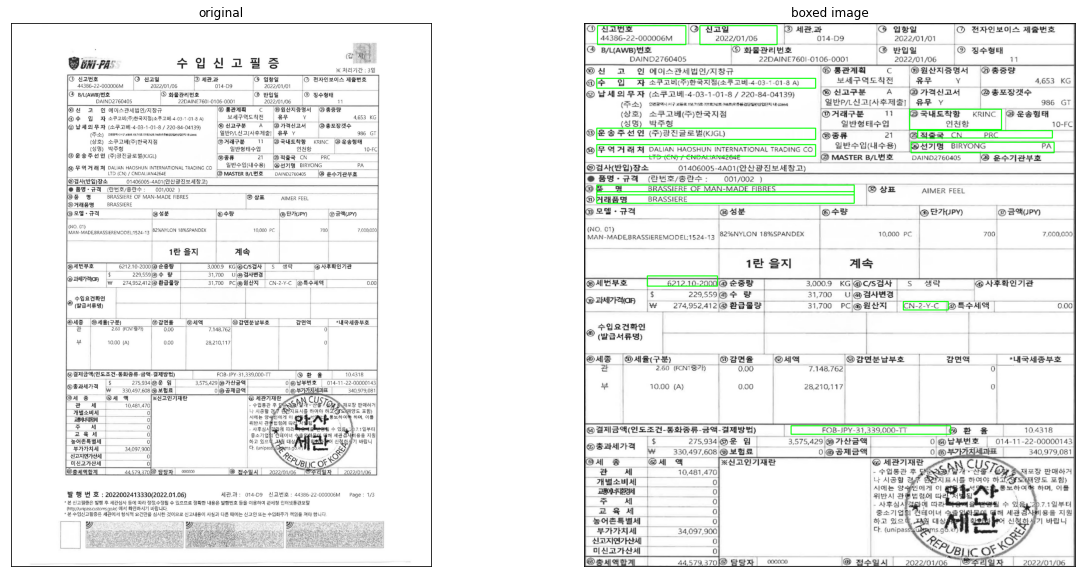

{'ORG_수입신고필증': {'신고번호': '44386-22-0000O6M', '신고일': '2022/01/06', '수입자': '소구고나 (주)한국지점 (소주 고네4037018 A)', '운송주선인': '(주)광진글로벌(KJGL)', '무역거래처': 'DALIAN HAOSHUN INTERNATIONAL RAIINC CO', '국내도착항': 'KRINC 인전항', '적출국': 'CN PR', '선기명': 'BIRYONG PA', '품명': 'BRASSIERE OF MANMADE FIBRES', '거래품명': 'BRASSIERE', '세부번호': '6212.10-2000', '원산지': 'CN--YC', '결제금액': 'FOB-JPY-31,339,000-TT'}, 'meta': {'imageSize': {'width': 1400, 'height': 1550}, 'domain': 'Import_declaration_certificate', 'version': 'v0.3.0', 'ocrToolName': 'Easy OCR', 'ocrTool': '4.1.1-rc2-25-g9707', 'language': 'ko, en', 'annotations': [{'label': '신고번호', 'text': '44386-22-0000O6M', 'boundingBox': [[38, 10], [290, 10], [290, 64], [38, 64]]}, {'label': '신고일', 'text': '2022/01/06', 'boundingBox': [[330, 10], [550, 10], [550, 64], [330, 64]]}, {'label': '수입자', 'text': '소구고나 (주)한국지점 (소주 고네4037018 A)', 'boundingBox': [[36, 160], [660, 160], [660, 188], [36, 188]]}, {'label': '운송주선인', 'text': '(주)광진글로벌(KJGL)', 'boundingBox': [[36, 302], [660, 

In [38]:
image_file = '../output/수입면장-PDF-img16.jpg'
image = cv2.imread(image_file)

# url = 'http://www.sgmarine.kr/files/attach/images/645/791/001/80ed53c3f656b7f56095154321c7cfd8.jpg'
 
# image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
# image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 
# dim = (1346, 1732)
  
# # resize image
# resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
# image = resized

org_image = image

json_file = '../std-json/ORG_Import_declaration_certificate.json'

bboxes, change_image, json_object = recognize_text(image, json_file)

draw_image = change_image.copy()
for bounding_box in bboxes:
    cv2.drawContours(draw_image, [bounding_box], -1, (0, 255, 0), 2)

plt_imshow(['original', 'boxed image'], [org_image, draw_image])
print(json_object)

In [ ]:
# custom_config = r'-l kor+eng --psm 6'
custom_config = r'-l kor+eng --psm 4'
text = pytesseract.image_to_string(gray, config=custom_config)

In [ ]:
langs = ['ko', 'en']
 
print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=False)
results = reader.readtext(change_image)
results

In [ ]:
simple_results = reader.readtext(image, detail = 0, paragraph=True)
simple_results